<a href="https://colab.research.google.com/github/veronichaflasma/Dicoding-Machine-Learning/blob/main/Final_Project_Animals_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project: Image Classification Model Deployment**
**Flasma Veronicha Hendryanna**

# **Import the Libraries**

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import pathlib
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
import shutil

from plotly.subplots import make_subplots
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import Callback

# **Import Datasets from Kaggle**

In [ ]:
# Install Kaggle package
!pip install -q Kaggle

# Upload Kaggle API
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"veronichaflasmah","key":"3a3b58ae6648d5760f9a96bae5cea52d"}'}

In [ ]:
# Create directory and change the permission
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
# Download and copy the dataset's API
!kaggle datasets download -d viratkothari/animal10

 97% 569M/585M [00:05<00:00, 167MB/s]
100% 585M/585M [00:05<00:00, 103MB/s]


In [ ]:
# Unzip the dataset
!mkdir animals
!unzip animal10.zip -d animals
!ls animals

Streaming output truncated to the last 5000 lines.
  inflating: animals/Animals-10/spider/spider (2374).jpeg  
  inflating: animals/Animals-10/spider/spider (2375).jpeg  
  inflating: animals/Animals-10/spider/spider (2376).jpeg  
  inflating: animals/Animals-10/spider/spider (2377).jpeg  
  inflating: animals/Animals-10/spider/spider (2378).jpeg  
  inflating: animals/Animals-10/spider/spider (2379).jpeg  
  inflating: animals/Animals-10/spider/spider (238).jpeg  
  inflating: animals/Animals-10/spider/spider (238).jpg  
  inflating: animals/Animals-10/spider/spider (2380).jpeg  
  inflating: animals/Animals-10/spider/spider (2381).jpeg  
  inflating: animals/Animals-10/spider/spider (2382).jpeg  
  inflating: animals/Animals-10/spider/spider (2383).jpeg  
  inflating: animals/Animals-10/spider/spider (2384).jpeg  
  inflating: animals/Animals-10/spider/spider (2385).jpeg  
  inflating: animals/Animals-10/spider/spider (2386).jpeg  
  inflating: animals/Animals-10/spider/spider (2387)

# **Read the Datasets**

In [ ]:
dir_data = "/content/animals/Animals-10"
total_class = [f.name for f in os.scandir(dir_data) if f.is_dir()]
animal_classes = len(total_class)
print("Total Class:", animal_classes)

Total Class: 10


In [ ]:
list_animal = os.listdir(dir_data)
print(list_animal)

['elephant', 'horse', 'chicken', 'cat', 'cow', 'dog', 'spider', 'sheep', 'squirrel', 'butterfly']


Reduce Class from 10 classes to 4 classes

In [ ]:
main_dataset_folder = '/content/animals/Animals-10'
folders_to_delete = ['cat', 'dog', 'elephant','horse','sheep', 'squirrel']
for folder_name in folders_to_delete:
    folder_to_delete = os.path.join(main_dataset_folder, folder_name)
    shutil.rmtree(folder_to_delete)


In [ ]:
list_animal = os.listdir(dir_data)
print(list_animal)

['chicken', 'cow', 'spider', 'butterfly']


In [ ]:
total_animal = 0

for animal in list_animal:
    dir = os.path.join(dir_data, animal)
    total = len(os.listdir(dir))
    print(animal+':', total)
    total_animal = total_animal + total

print('\nTotal Animal Datasets: ', total_animal)

chicken: 3098
cow: 1866
spider: 4821
butterfly: 2112

Total Animal Datasets:  11897


# **Display Images of Datasets**

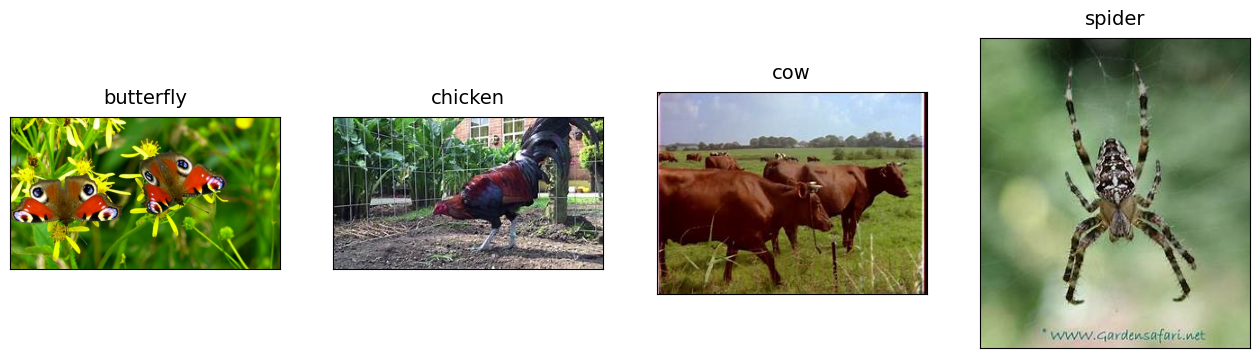

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(16, 16))

animal_sorted = sorted(list_animal)
animal_id = 0

for ax_index in range(4):
    if animal_id >= len(animal_sorted):
        break

    animal_selected = animal_sorted[animal_id]
    animal_id += 1

    if animal_selected == '.TEMP':
        continue

    animal_selected_images = os.listdir(os.path.join(dir_data, animal_selected))
    animal_selected_random = np.random.choice(animal_selected_images)
    img = plt.imread(os.path.join(dir_data, animal_selected, animal_selected_random))
    ax[ax_index].imshow(img)
    ax[ax_index].set_title(animal_selected, pad=10, fontsize=14)

plt.setp(ax, xticks=[], yticks=[])
plt.show()

# **Data preprocessing**

In [ ]:
IMG_SIZE = 150 # Rescale all input images
BATCH_SIZE = 256

In [ ]:
train_gen = ImageDataGenerator(
    rotation_range= 30,
    width_shift_range= 0.15,
    height_shift_range= 0.15,
    rescale= 1/255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    fill_mode= 'nearest',
    validation_split= 0.2
)

In [ ]:
train_data = train_gen.flow_from_directory(
    dir_data,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size= BATCH_SIZE,
    class_mode='categorical',
    subset='training')

val_data = train_gen.flow_from_directory(
    dir_data,
    target_size= (IMG_SIZE, IMG_SIZE),
    batch_size= BATCH_SIZE,
    class_mode= 'categorical',
    subset= 'validation')

Found 9519 images belonging to 4 classes.
Found 2378 images belonging to 4 classes.


# **Training Callbacks**

In [ ]:
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92:
            print("\nReached the Accuracy. Stop Training.")
            self.model.stop_training = True

callbacks = myCallback()

# **First Model**

In [ ]:
animalModel = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

animalModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
animalModel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = animalModel.fit(train_data,
                       validation_data = val_data,
                       validation_steps = val_data.samples // BATCH_SIZE,
                       epochs = 200,
                       steps_per_epoch = train_data.samples // BATCH_SIZE,
                       verbose = 1,
                       callbacks = [callbacks])

Epoch 1/200
37/37 [==============================] - 115s 3s/step - loss: 1.2705 - accuracy: 0.4176 - val_loss: 1.1454 - val_accuracy: 0.5043
Epoch 2/200
37/37 [==============================] - 83s 2s/step - loss: 1.0310 - accuracy: 0.5613 - val_loss: 0.9214 - val_accuracy: 0.6328
Epoch 3/200
37/37 [==============================] - 79s 2s/step - loss: 0.8777 - accuracy: 0.6580 - val_loss: 0.7849 - val_accuracy: 0.6888
Epoch 4/200
37/37 [==============================] - 80s 2s/step - loss: 0.7696 - accuracy: 0.7052 - val_loss: 0.6484 - val_accuracy: 0.7591
Epoch 5/200
37/37 [==============================] - 81s 2s/step - loss: 0.6399 - accuracy: 0.7641 - val_loss: 0.5859 - val_accuracy: 0.7804
Epoch 6/200
37/37 [==============================] - 78s 2s/step - loss: 0.5790 - accuracy: 0.7855 - val_loss: 0.5644 - val_accuracy: 0.8069
Epoch 7/200
37/37 [==============================] - 83s 2s/step - loss: 0.5401 - accuracy: 0.7970 - val_loss: 0.5468 - val_accuracy: 0.8025
Epoch 8/200


# **Plotting Accuracy and Loss Model**

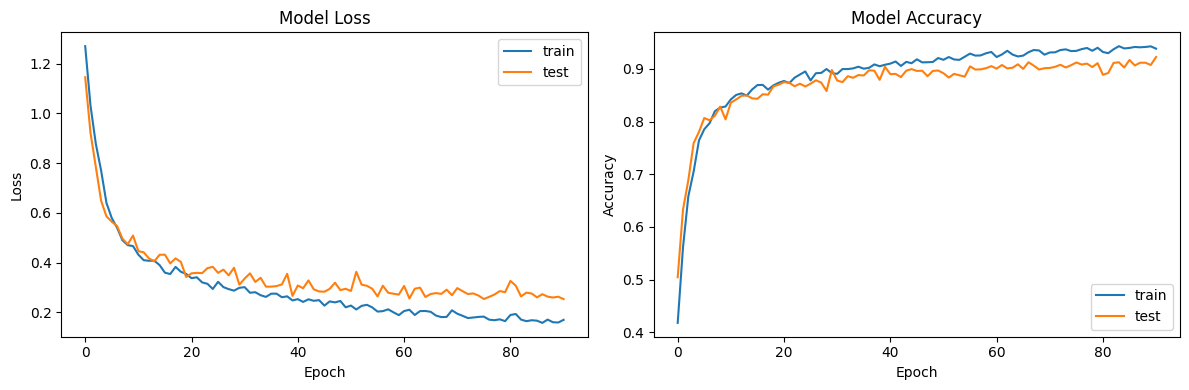

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_title('Model Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['train', 'test'], loc='upper right')

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].set_title('Model Accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(['train', 'test'], loc='lower right')


plt.tight_layout()
plt.show()

# **Save Model**

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(animalModel)
tflite_model = converter.convert()

output_directory = 'tflite_models/'
tf.io.gfile.makedirs(output_directory)

tflite_model_path = tf.io.gfile.GFile(output_directory + 'AnimalClassModel.tflite', 'wb')
tflite_model_path.write(tflite_model)